# Overview

* Estimativa de profundidade monocular auto-supervisionada constrói um modelo de profundidade simples e o treina de maneira auto-supervisionada, explorando a restrição da geometria espacial.

* Uma arquitetura U-Net simpleS, que combina vários recursos de escala com diferentes tamanhos de campo receptivo. Ele agrupa os mapas de recursos em tamanhos diferentes e, em seguida, concatena-os após o aumento da resolução.

## Paper citation

> **High Quality Monocular Depth Estimation via Transfer Learning**
>
> [Ibraheem Alhashim](https://ialhashim.github.io/) and Peter Wonka
>
> [ICCV 2018 (arXiv pdf)](https://arxiv.org/abs/1812.11941)


```
@article{Alhashim2018,
  author    = {Ibraheem Alhashim and Peter Wonka},
  title     = {High Quality Monocular Depth Estimation via Transfer Learning},
  journal   = {arXiv e-prints},
  volume    = {abs/1812.11941},
  year      = {2018},
  url       = {https://arxiv.org/abs/1812.11941},
  eid       = {arXiv:1812.11941},
  eprint    = {1812.11941}
}
```


Links uteis: https://github.com/ialhashim/DenseDepth, https://github.com/siddinc/monocular_depth_estimation, https://keras.io/examples/vision/depth_estimation/


# 1. Importe de bibliotecas

In [17]:
import os
import sys
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
tf.random.set_seed(123)

# 2. Define Hiperparametros

In [18]:
HEIGHT = 128
WIDTH = 128
LR = 0.0001
EPOCHS = 30
TRAIN_PATH = "./data/nyu2_train.csv"
TEST_PATH = "./data/nyu2_test.csv"

# 3. Carrega o Dataset NYU

https://cs.nyu.edu/~fergus/datasets/nyu_depth_v2.html

O conjunto de dados NYU-Depth V2 é composto por sequências de vídeo de uma variedade de cenas internas, conforme registradas pelas câmeras RGB e Depth do Microsoft Kinect . Ele apresenta:

1449 pares densamente rotulados de imagens RGB e de profundidade alinhadas
464 novas cenas tiradas de 3 cidades
407.024 novos quadros sem etiqueta
Cada objeto é rotulado com uma classe e um número de instância (cup1, cup2, cup3, etc.)
O conjunto de dados tem vários componentes:

Labeled: Um subconjunto dos dados de vídeo acompanhados por rótulos multiclasse densos. Esses dados também foram pré-processados ​​para preencher rótulos de profundidade ausentes.
Raw: Dados brutos de rgb, profundidade e acelerômetro fornecidos pelo Kinect.
Caixa de ferramentas: Funções úteis para manipular dados e rótulos.

In [19]:
!git clone https://gitlab.com/siddinc/new_depth.git ./data

fatal: destination path './data' already exists and is not an empty directory.


#4. Carrega o Dataset NYU
* ARQUIVOS CSV
* IMAGENS DE TREINO
* IMAGENS DE VALIDAÇÃO

In [25]:
class LoadDataset():
    def read_csv(self, csv_file_path):
      with open(csv_file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        return [('./' + row[0], './' + row[1]) for row in csv_reader if len(row) > 0]

    def train_val_split(self, train_paths, val_size):
      random.shuffle(train_paths)
      len_train_paths = len(train_paths)
      i = int(len_train_paths*(1.0 - val_size))
      train = train_paths[0:i]
      val = train_paths[i:len(train_paths)]
      return train, val

    def load_train_paths(self, train_path):
      train_paths = self.read_csv(train_path)
      labels = {img_path: dm_path for img_path, dm_path in train_paths}
      x_paths = [img_path for img_path, dm in train_paths]
      x_train_paths, x_val_paths = self.train_val_split(x_paths, 0.3)

      return x_train_paths, x_val_paths, labels

In [26]:
train, validation, labels = LoadDataset().load_train_paths(TRAIN_PATH)
print(len(train), len(validation))

22437 9617


# 5. Preprocessa e Normaliza o Dataset NYU


O código da classe PreprocessDataset define métodos para normalizar e pré-processar imagens e mapas de profundidade. O método normalize_img normaliza os valores dos pixels para o intervalo [0, 1]. O método preprocess_image lê uma imagem, redimensiona-a para uma altura específica, recorta uma seção horizontal, normaliza os valores dos pixels e, opcionalmente, inverte a imagem horizontalmente. O método preprocess_depth_map realiza operações semelhantes em um mapa de profundidade, incluindo a conversão para escala de cinza e a adição de uma dimensão extra para compatibilidade com modelos que esperam entradas tridimensionais. Ambos os métodos usam as bibliotecas OpenCV (cv2) e imutils.

In [27]:
class PreprocessDataset():
    def normalize_img(self, img):
        norm_img = (img - img.min()) / (img.max() - img.min())
        return norm_img

    def preprocess_image(self, img_path, horizontal_flip=False):
      image = cv2.imread(img_path)
      image = imutils.resize(image, height=HEIGHT)
      image = image[:, 21:149].astype("float")
      image = self.normalize_img(image)

      if horizontal_flip:
        image = cv2.flip(image, 1)
      return image

    def preprocess_depth_map(self, depth_map_path, horizontal_flip=False):
      depth_map = cv2.imread(depth_map_path)
      depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
      depth_map = imutils.resize(depth_map, height=HEIGHT)
      depth_map = depth_map[:, 21:149].astype("float")
      depth_map = self.normalize_img(depth_map)

      if horizontal_flip:
        depth_map = cv2.flip(depth_map, 1)

      depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
      return depth_map

#6. Construindo um pipeline de dados

O código define uma classe DataGenerator que herda de Sequence e é usada para gerar lotes de dados para treinamento de modelos em deep learning. O construtor inicializa parâmetros como tamanho do lote, dimensões das imagens, número de canais, se os dados devem ser embaralhados e se é para previsão. O método __len__ retorna o número de lotes por época. O método __getitem__ gera um lote de dados e, opcionalmente, seus rótulos se não for previsão. O método on_epoch_end atualiza os índices dos dados e os embaralha se necessário. O método __data_generation pré-processa as imagens e mapas de profundidade, utilizando a classe PreprocessDataset para normalizar e aplicar transformações opcionais como a inversão horizontal.

In [28]:
# data generator
class DataGenerator(Sequence):
  def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.pred = pred
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    if self.pred:
      X = self.__data_generation(list_IDs_temp)
      return X
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

    if not self.pred:
      y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = PreprocessDataset().preprocess_image(ID, res)
        y[i,] = PreprocessDataset().preprocess_depth_map(self.labels[ID], res)
      return X, y
    else:
      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = PreprocessDataset().preprocess_image(ID, res)
      return X

In [29]:
training_generator = DataGenerator(list_IDs=train, labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=validation, labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

## 7. Construindo o modelo

1. O modelo básico é da U-Net.
2. Conexões de salto são implementadas no bloco de redução de escala.

In [36]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

#8. Função de perda e métrica de acuracia

In [37]:
class Metrics():
    def depth_loss_function(self, y_true, y_pred):

        # Point-wise depth
        l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

        # Edges
        dy_true, dx_true = tf.image.image_gradients(y_true)
        dy_pred, dx_pred = tf.image.image_gradients(y_pred)
        l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

        # Structural similarity (SSIM) index
        l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, max_val=1.0)) * 0.5, 0, 1)

        # Weights
        w1 = 1.0
        w2 = 1.0
        w3 = 0.1

        return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

    def depth_acc(self, y_true, y_pred):
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# 9. Método de Execução do Modelo
* Carrega as saidas e entradas do modelo (encoder e decoder)


In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)

model = DepthEstimationModel()
model.compile(optimizer=optimizer, loss=Metrics().depth_loss_function, metrics=[Metrics().depth_acc])
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS)

Epoch 1/30
1402/1402 [==============================] - 455s 316ms/step - loss: 0.2696 - depth_acc: 0.6779 - val_loss: 0.2303 - val_depth_acc: 0.6933
Epoch 2/30
1402/1402 [==============================] - 432s 308ms/step - loss: 0.2208 - depth_acc: 0.7473 - val_loss: 0.2122 - val_depth_acc: 0.7632
Epoch 3/30
1402/1402 [==============================] - 424s 303ms/step - loss: 0.2062 - depth_acc: 0.7802 - val_loss: 0.1998 - val_depth_acc: 0.7941
Epoch 4/30
1402/1402 [==============================] - 423s 302ms/step - loss: 0.1945 - depth_acc: 0.8049 - val_loss: 0.1897 - val_depth_acc: 0.8076
Epoch 5/30
1402/1402 [==============================] - 431s 307ms/step - loss: 0.1849 - depth_acc: 0.8236 - val_loss: 0.1780 - val_depth_acc: 0.8311
Epoch 6/30
1402/1402 [==============================] - 421s 300ms/step - loss: 0.1753 - depth_acc: 0.8399 - val_loss: 0.1716 - val_depth_acc: 0.8447
Epoch 7/30
1402/1402 [==============================] - 429s 306ms/step - loss: 0.1690 - depth_acc: 

#10. Histograma de perda por iteração das épocas

KeyError: 'depth_acc'

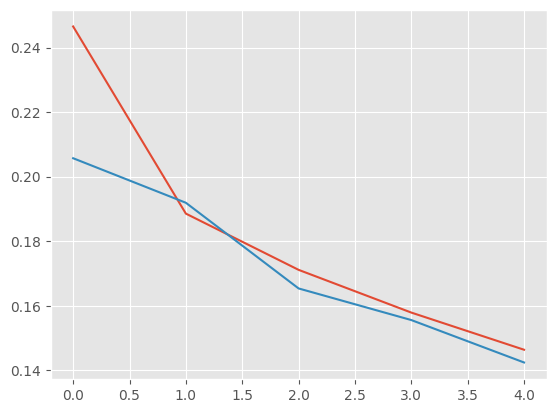

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# e = np.linspace(1, EPOCHS, num=EPOCHS)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['depth_acc'], label='acc')
plt.plot(r.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

In [ ]:
img_dm_pairs = read_csv('./data/nyu2_test.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

654


In [ ]:
x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [ ]:
print(model.evaluate(x_test, y_test))

654/654 [==============================] - 5s 7ms/step
[0.2614277615368549, 0.8280850648880005]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(x_test)

21/21 [==============================] - 4s 80ms/step


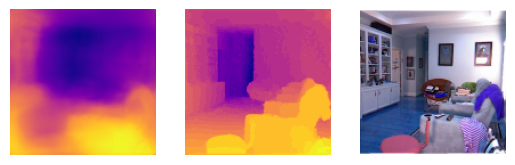

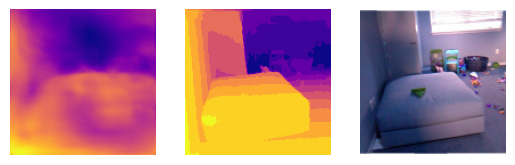

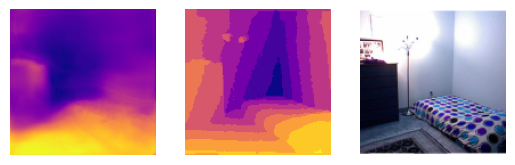

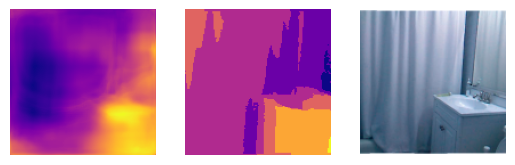

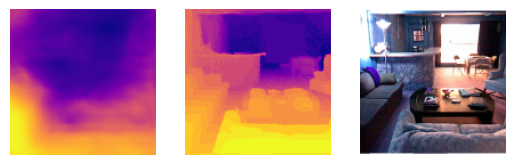

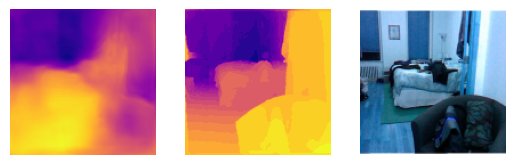

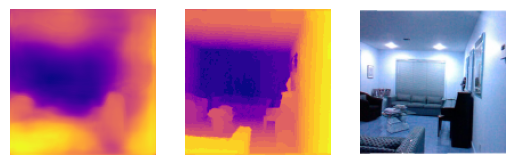

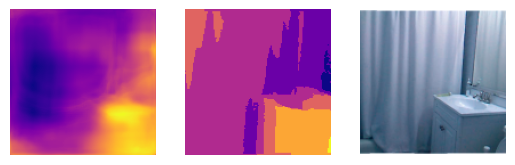

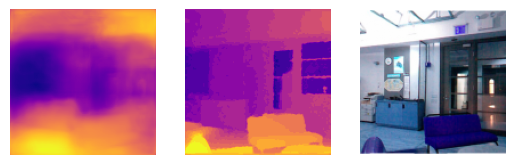

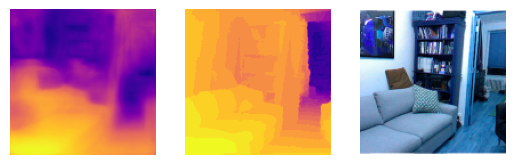

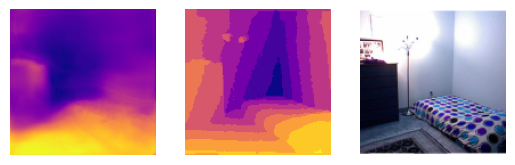

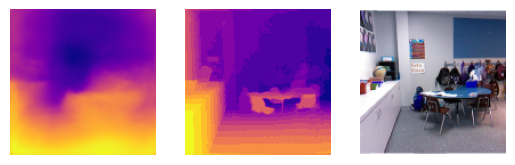

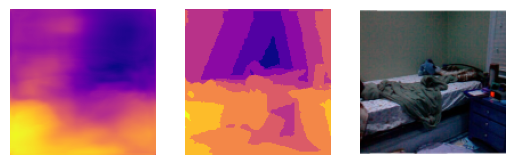

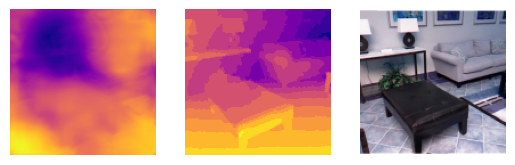

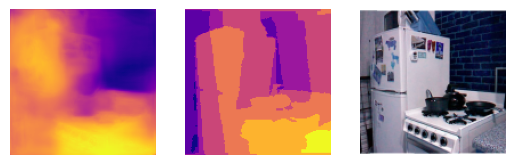

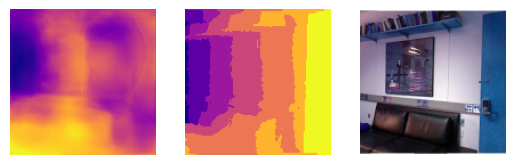

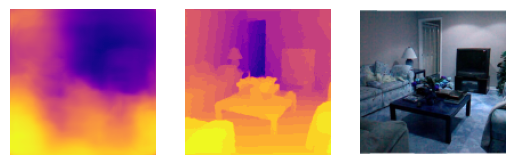

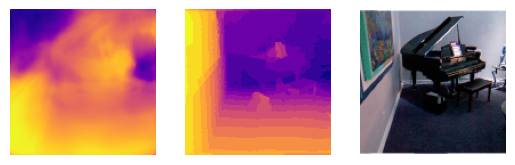

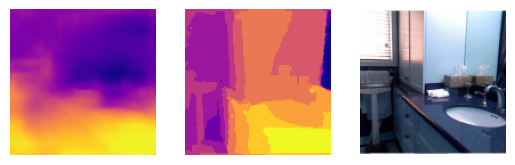

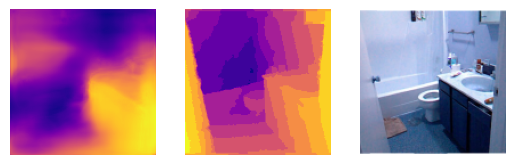

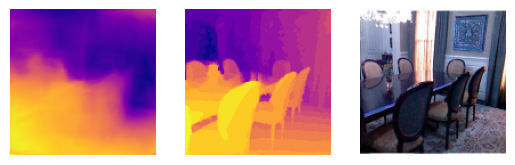

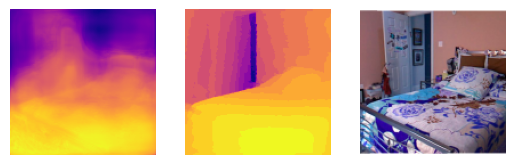

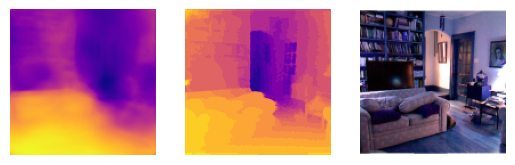

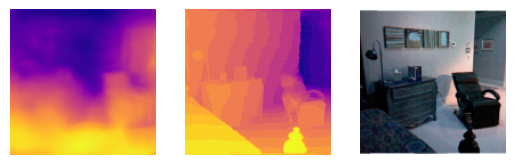

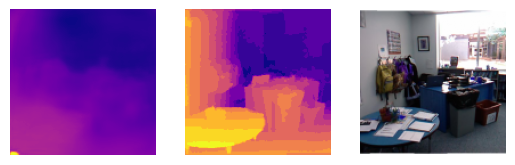

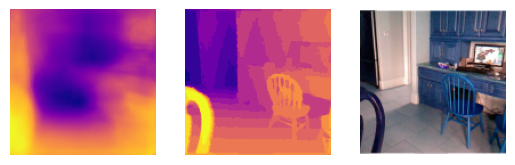

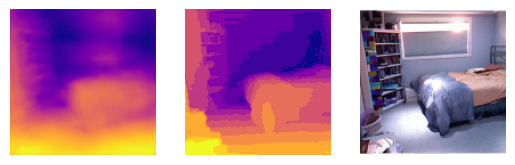

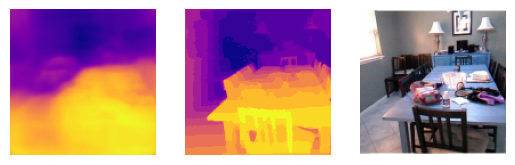

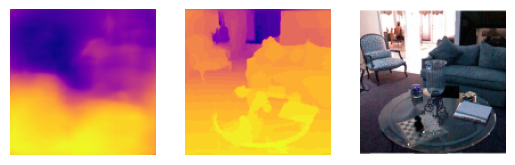

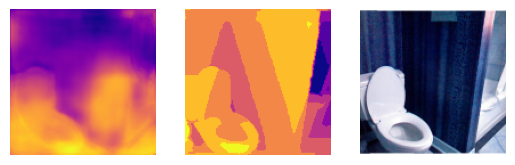

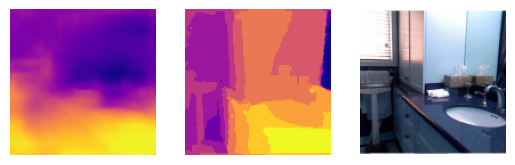

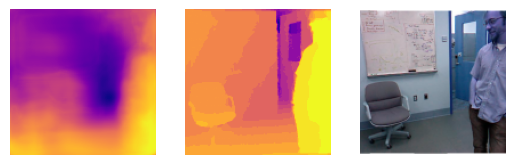

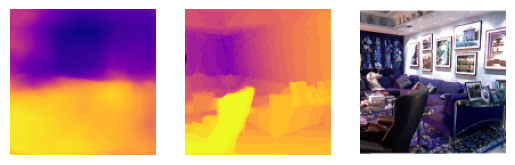

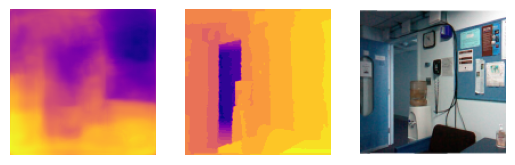

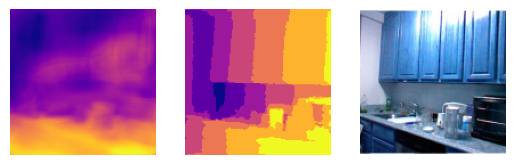

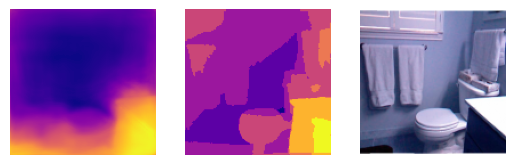

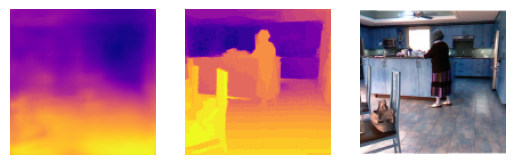

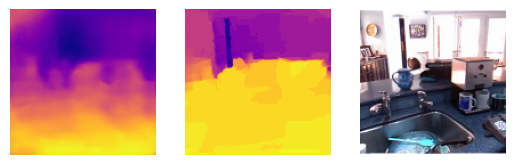

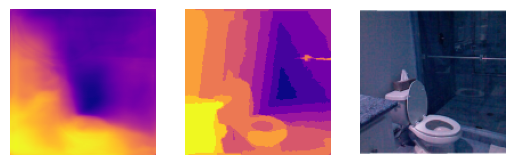

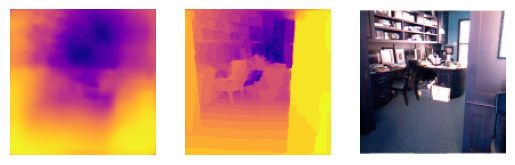

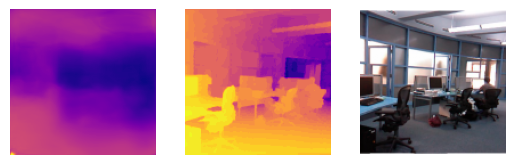

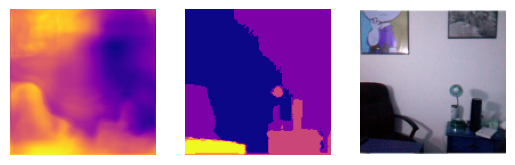

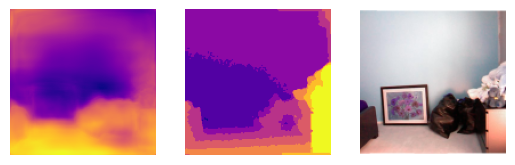

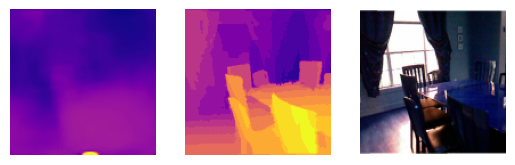

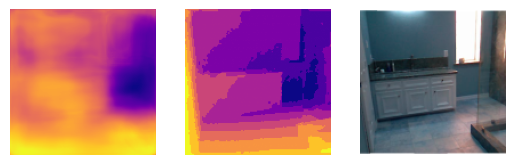

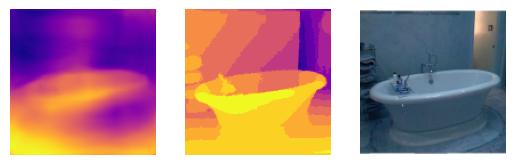

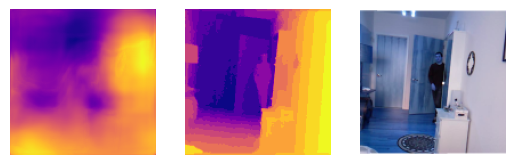

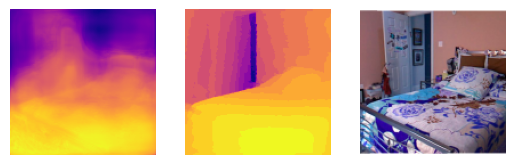

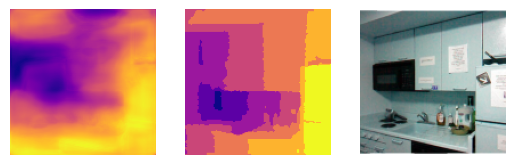

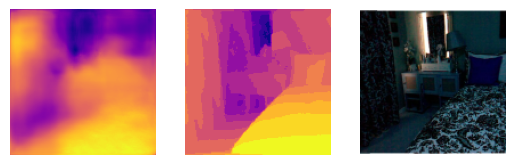

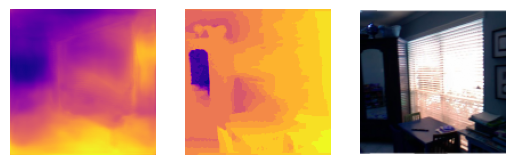

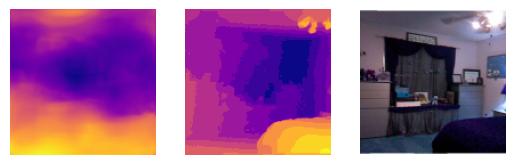

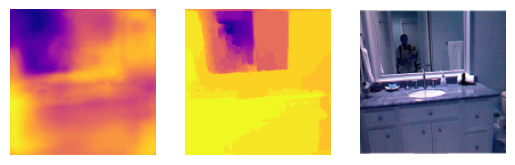

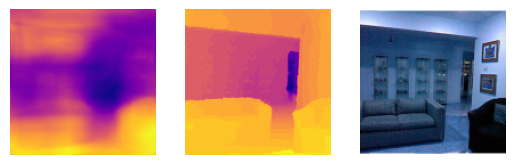

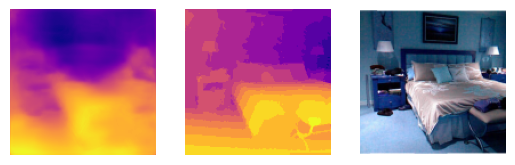

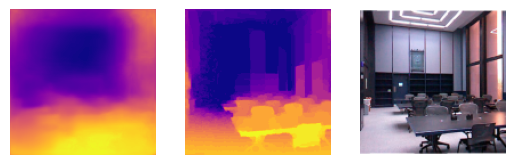

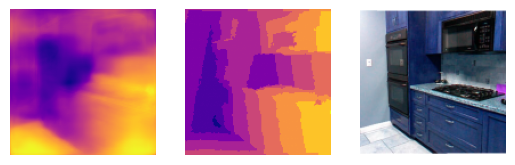

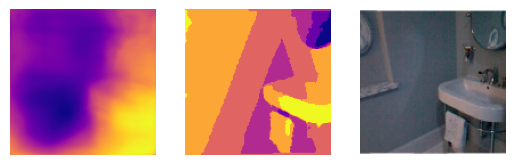

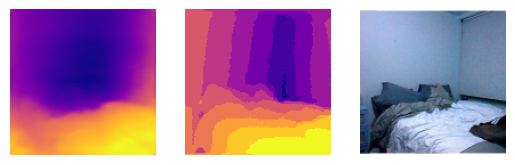

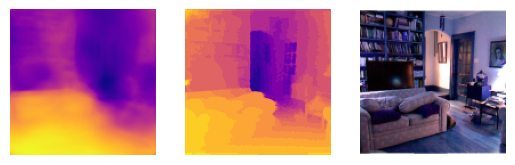

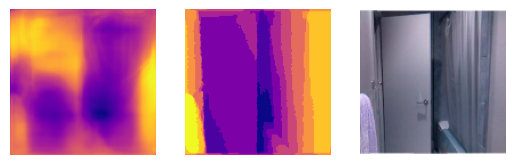

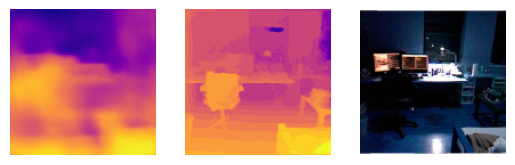

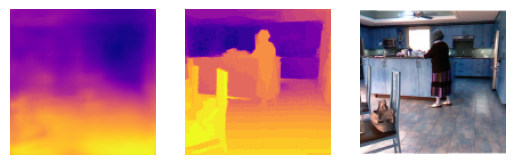

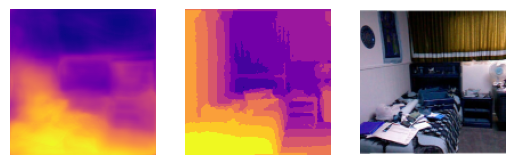

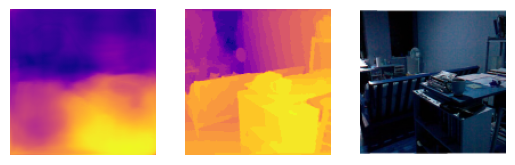

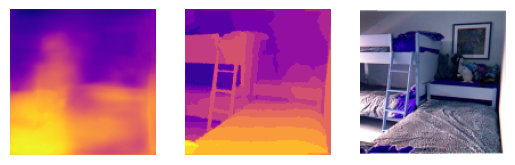

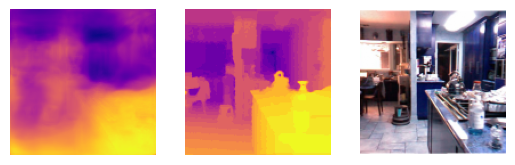

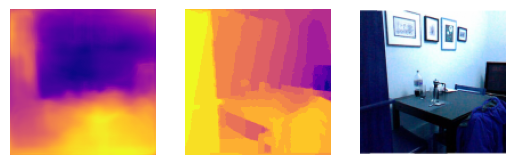

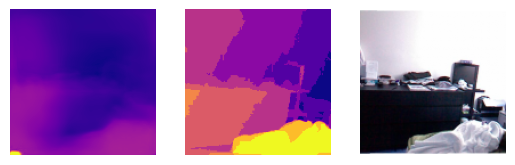

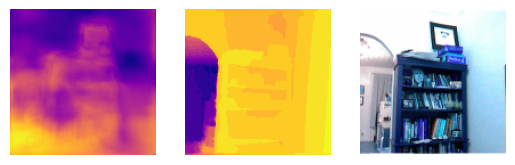

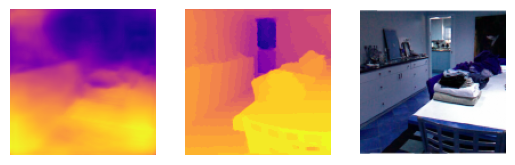

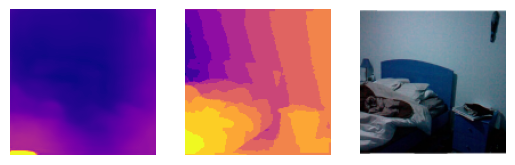

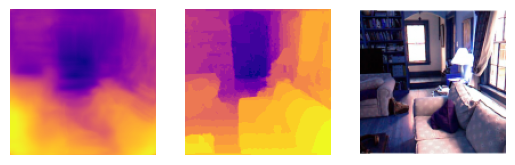

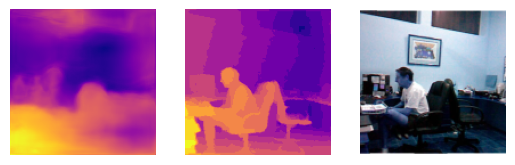

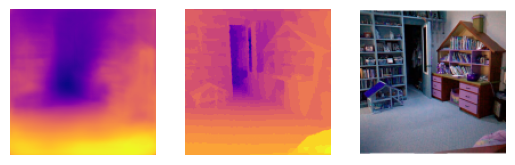

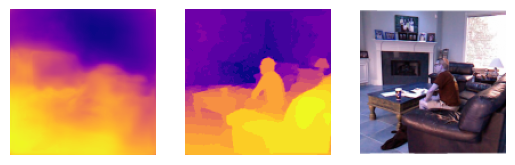

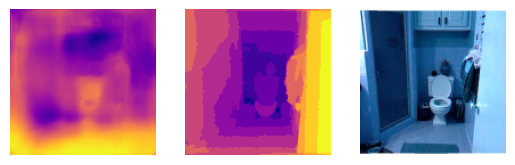

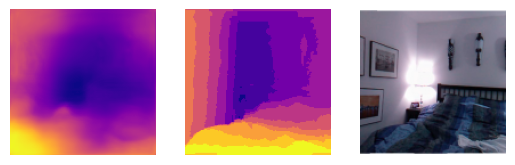

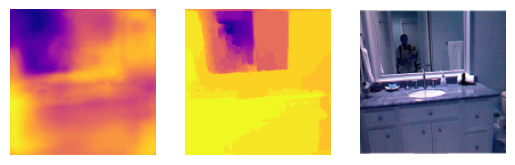

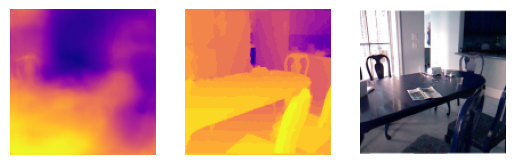

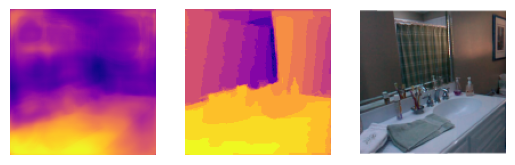

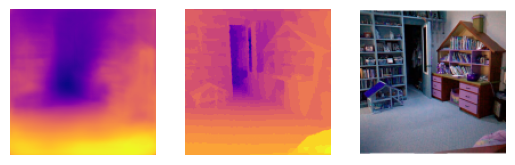

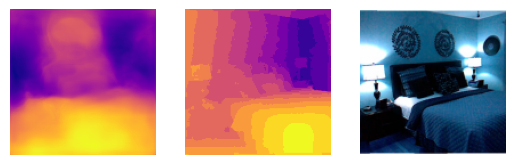

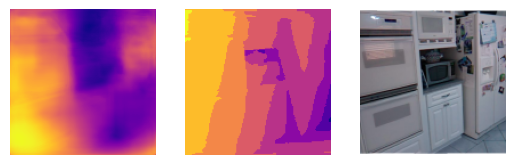

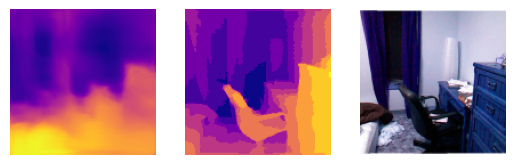

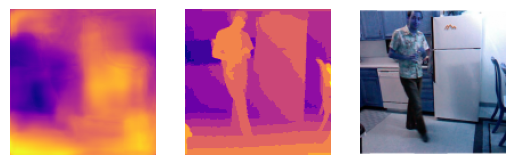

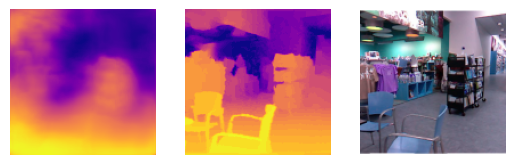

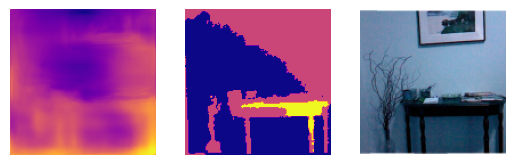

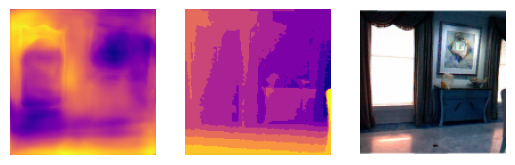

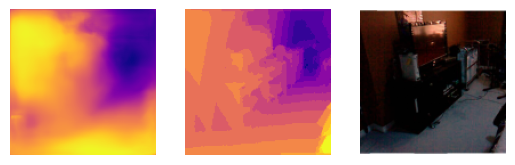

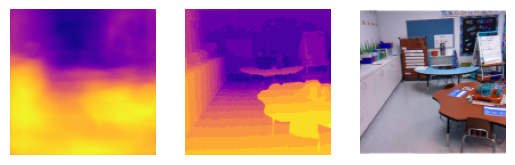

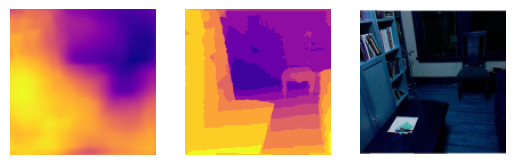

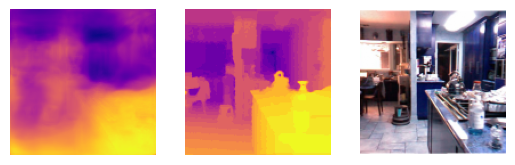

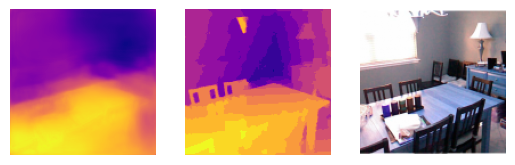

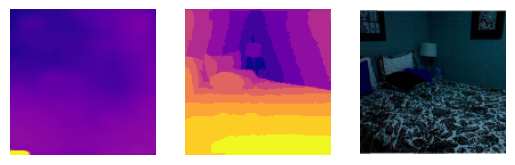

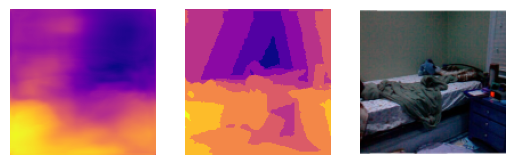

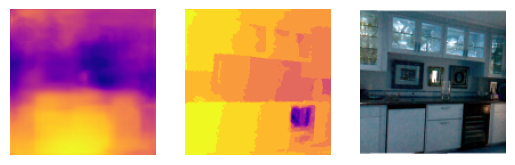

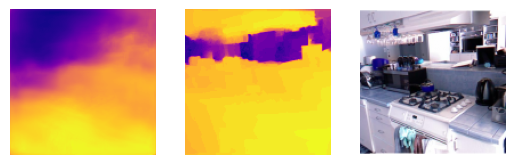

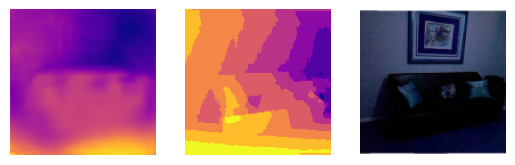

Exception ignored in: <function _xla_gc_callback at 0x7debde19e440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


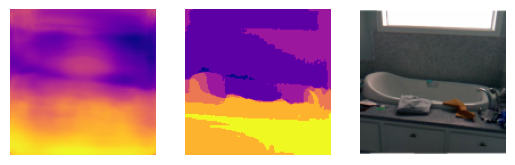

In [ ]:
indices = np.random.randint(0, len(test_paths), 100)
cmap = "plasma_r"

for i in indices:
  path = partition['test'][i]
  label_path = labels[path]
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)

  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = preprocess_depth_map(label_path, horizontal_flip=False)
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = preprocess_image(path, horizontal_flip=False)
  plt.imshow(img1)

  plt.show()

In [ ]:
model.to_json()

# 7. Executa a predição das imagens carregadas e imprimi os resultados lado a lado


In [ ]:
import matplotlib.pyplot as plt

# Faz a predição no lote de imagens
result_img = model.predict(input_images)

# Configurar subplots para 20 linhas e 2 colunas
fig, axes = plt.subplots(20, 2, figsize=(20, 100))

# Iterar sobre as primeiras 20 imagens
for i in range(20):
    # Número da imagem no lote que queremos visualizar
    val = i

    imin = input_images[val]
    imout = result_img[0][val].reshape(192, 640)  # Ajustar a forma da imagem de saída

     # Mostrar a imagem de entrada com legenda
    axes[i, 0].imshow(imin)
    axes[i, 0].set_title(f'b) Imagem de entrada {val}', fontsize=15)
    axes[i,0].axis('off')  # Ocultar os eixos

    # Mostrar a imagem de saída com legenda
    axes[i, 1].imshow(imout)  # Supondo que a saída seja uma imagem em escala de cinza
    axes[i, 1].set_title(f'a) Imagem de saída {val}', fontsize=15)
    axes[i, 1].axis('off')  # Ocultar os eixos


# Ajustar o layout para evitar sobreposição de títulos
plt.tight_layout()

# Exibir as imagens
plt.show()


# 9. Salva o modelo em TensorFlow

In [ ]:
path = '/content/tf'
tf.saved_model.save(model, path)

modelPreFinal = tf.saved_model.load(path)

# 10. Converte o modelo TensorFlow para TensorFlow Lite

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_alfa.tflite', 'wb') as f:
  f.write(tflite_model)

# 10.  Valida o modelo gerado em TensorFlow Lite

In [ ]:
TFLITE_MODEL = "model_alfa.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()
print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])
